In [1]:
from tensorflow.keras.models import load_model
import os
import sys
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
from tensorflow import keras
import json
from tensorflow.keras.applications import resnet_v2
import dlib

In [52]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        
        
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        #heatmap2 = cam.numpy().reshape(w,h)
       
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        
        #Return to BGR [0..255] from the preprocessed image
#     image = image[0, :]
#     image -= np.min(image)
#     image = np.minimum(image, 255)

#     cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
#     cam = np.float32(cam) + np.float32(image)
#     cam = 255 * cam / np.max(cam)
#     return np.uint8(cam), heatmap

        return heatmap
    
    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)
    
def detect_face(image_path, im_size = 224, default_max_size=800,size = 300, padding = 0.25):
    cnn_face_detector = dlib.cnn_face_detection_model_v1('./dlib_mod/mmod_human_face_detector.dat')
    sp = dlib.shape_predictor('./dlib_mod/shape_predictor_5_face_landmarks.dat')
    base = 2000  # largest width and height

    img = dlib.load_rgb_image(image_path)
    old_height, old_width, _ = img.shape
    old_height, old_width, _ = img.shape

    if old_width > old_height:
        new_width, new_height = default_max_size, int(default_max_size * old_height / old_width)
    else:
        new_width, new_height =  int(default_max_size * old_width / old_height), default_max_size
    img = dlib.resize_image(img, rows=new_height, cols=new_width)
    dets = cnn_face_detector(img, 1)
    num_faces = len(dets)
    if num_faces == 0:
        print("Sorry, there were no faces found in '{}'".format(image_path))
        return
    elif num_faces > 1:
        print("Multiple face in '{}'. A random face will be returned".format(image_path))
    faces = dlib.full_object_detections()
    for detection in dets:
        rect = detection.rect
        faces.append(sp(img, rect))
    image = dlib.get_face_chips(img, faces, size=size, padding = padding)[0]

    image = Image.fromarray(image, 'RGB')
    image = image.resize((im_size, im_size))

    #image = np.array(image) / 255.0
    #ori_img = np.array(image)
    processed_img = resnet_v2.preprocess_input(np.array(image))
    processed_img = processed_img[None,:]
    return processed_img, image

In [31]:
with open("./config/parameters.json") as f:
    data = json.load(f)
f.close()

model_param = data["model_param"]
lr, epochs, batch_size, mapping_path, save_path, log_path = model_param.values()

In [32]:
with open(mapping_path) as f:
    mapping = json.load(f)
f.close()

In [33]:
mapping

{'Black': 0,
 'East Asian': 1,
 'Indian': 2,
 'Latino_Hispanic': 3,
 'Middle Eastern': 4,
 'Southeast Asian': 5,
 'White': 6}

In [18]:
model = load_model(save_path)

In [39]:
#sample_img = '/teams/DSC180A_FA20_A00/a01explainableai/a01capstonegroup03/fairface_pad025/val/2583.jpg'
sample_img = "./IMG_3533.jpg"

In [40]:
#img_arr = plt.imread(sample_img)
#img_arr = resnet_v2.preprocess_input(img_arr)
img_arr,ori_img = detect_face(sample_img)

In [41]:
pred = model.predict(img_arr.reshape(-1, 224,224,3))

In [42]:
class_idx = np.argmax(pred)

In [55]:
cam = GradCAM(model, class_idx)

In [56]:
heatmap = cam.compute_heatmap(img_arr.reshape(-1, 224, 224, 3))

In [57]:
#img_ori = plt.imread(sample_img)
img_ori = np.array(ori_img)
(heatmap, output) = cam.overlay_heatmap(heatmap, img_ori, alpha=0.7)

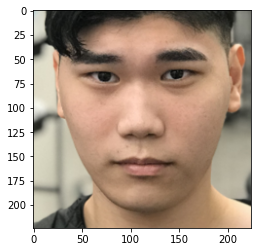

In [58]:
plt.imshow(img_ori)

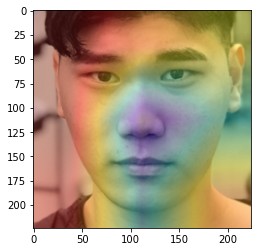

In [59]:
plt.imshow(output)

In [60]:
sample_img = '/teams/DSC180A_FA20_A00/a01explainableai/a01capstonegroup03/fairface_pad025/val/2583.jpg'
img_arr = plt.imread(sample_img)
img_arr = resnet_v2.preprocess_input(img_arr)
pred = model.predict(img_arr.reshape(-1, 224,224,3))
class_idx = np.argmax(pred)
cam = GradCAM(model, class_idx)
heatmap = cam.compute_heatmap(img_arr.reshape(-1, 224, 224, 3))
img_ori = plt.imread(sample_img)
(heatmap, output) = cam.overlay_heatmap(heatmap, img_ori, alpha=0.5)

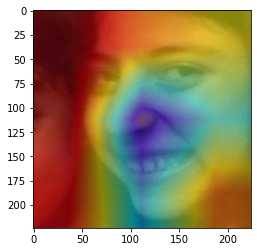

In [61]:
plt.imshow(output)

In [ ]:
heatmap[0].shape

In [8]:
heatmap

(array([[[127,   0,   0],
         [127,   0,   0],
         [127,   0,   0],
         ...,
         [  1, 253, 252],
         [  1, 253, 252],
         [  1, 253, 252]],
 
        [[127,   0,   0],
         [127,   0,   0],
         [127,   0,   0],
         ...,
         [  1, 253, 252],
         [  1, 253, 252],
         [  1, 253, 252]],
 
        [[127,   0,   0],
         [127,   0,   0],
         [127,   0,   0],
         ...,
         [  1, 253, 252],
         [  1, 253, 252],
         [  1, 253, 252]],
 
        ...,
 
        [[  0,   0, 230],
         [  0,   0, 230],
         [  0,   0, 230],
         ...,
         [  0, 123, 253],
         [  0, 123, 253],
         [  0, 123, 253]],
 
        [[  0,   0, 230],
         [  0,   0, 230],
         [  0,   0, 230],
         ...,
         [  0, 123, 253],
         [  0, 123, 253],
         [  0, 123, 253]],
 
        [[  0,   0, 230],
         [  0,   0, 230],
         [  0,   0, 230],
         ...,
         [  0, 123, 253],
  